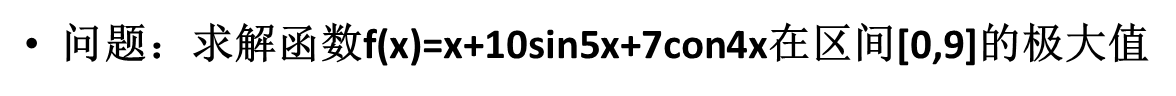

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

#coding:utf-8 
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号 #有中文出现的情况，需要u'内容'

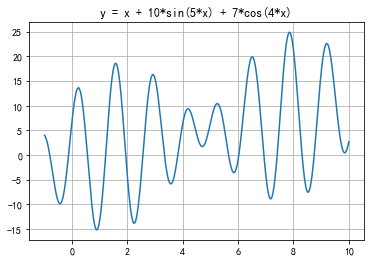

In [2]:
x = np.arange(-1, 10, 0.001)
y = x + 10*np.sin(5*x) + 7*np.cos(4*x)
plt.title("y = x + 10*sin(5*x) + 7*cos(4*x)")
plt.grid(True)
plt.plot(x, y)
plt.show()

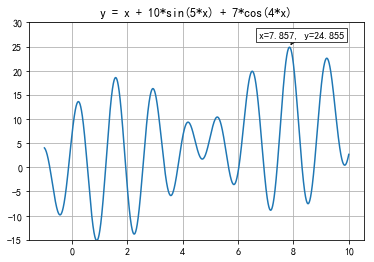

In [5]:
x = np.arange(-1, 10, 0.001)
y = x + 10*np.sin(5*x) + 7*np.cos(4*x)

fig, ax = plt.subplots()
ax.plot(x,y)

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)


ax.set_ylim(-15,30)
plt.title("y = x + 10*sin(5*x) + 7*cos(4*x)")
plt.grid(True)
plt.show()

### 编码

In [3]:
lower_bound = 0
upper_bound = 9
interval_length = upper_bound - lower_bound
precise = 5
#编码长度
coding_length = np.log2(interval_length* np.power(10,precise))
print(coding_length)
coding_length = int(np.ceil(coding_length))#ceil()向上取整
print(coding_length)
#20位二进制数最大可表示位 1048575 取模才能保证在给定区间内 1048575%(9*5*10 +1)
mold = interval_length*np.power(10,precise) + 1

19.7795654759
20


### 初始化种群

In [4]:
#初始种群大小
init_population_size = 20
copy_rate = 0.1

cross_rate = 0.6
mutate_rate = 0.01


population = np.array(np.random.rand(coding_length) > 0.5,dtype=bool)
for i in range(init_population_size - 1):
    single = np.array(np.random.rand(coding_length) > 0.5,dtype=bool)
    population = np.row_stack((population,single))
    
assert population.shape == (init_population_size, coding_length)

### 适应度函数

In [5]:
def fitness_function(individual):
    assert individual.shape == (coding_length,)
    x = decode(individual)
    return function(x)
def decode(individual):
    assert individual.shape == (coding_length,)
    str  =''
    for bit in individual:
        if bit:str += '1'
        else:str += '0'
    #int('01110', 2)二进制转十进制, (0 + number%modle)*0.00001
    x = (lower_bound + int(str,2)%mold) * np.power(0.1, precise)
    return x
def function(x):
    y = x + 10*np.sin(5*x) + 7*np.cos(4*x)
    return y

### 选择

In [6]:
def selection(population):
    rank = []
    index = 0
    for individual in population:
        score = fitness_function(individual)
        rank.append([score,index])
        index += 1;
    result_size = int(cross_rate * len(population))
    rank = np.array(rank)
    #print(rank)
    #按fitness value升序排序
    rank = rank[rank[:,0].argsort()]
    #print(rank)
    selection_result = []
    for i in range(0,len(population)):
        index = int(rank[len(population)- 1 - i][1])
        selection_result.append(population[index])
        #print(fitness_function(population[index]))
    selection_result = np.array(selection_result)
    return selection_result

### 交叉

In [7]:
def crossover(population, copy_rate, cross_rate):
    copy_size = int(copy_rate*len(population))
    cross_size = int(cross_rate*len(population))
    #直接保留至下一代
    result = np.copy(population[0:copy_size])
    for i in range(0, cross_size):
        #随机选择两个个体作为双亲
        father = population[random.randint(0, len(population)-1)]
        mother = population[random.randint(0, len(population)-1)]
        #print("parents: ",fitness_function(father), fitness_function(mother))
        #分别取前后半段
        pre_seg = np.split(father, 2, axis=0)[0]
        rear_seg = np.split(mother, 2, axis=0)[1]
        son = np.concatenate((pre_seg, rear_seg), axis = 0)
        assert len(son) == coding_length
        #print("son: ", fitness_function(son))
        result = np.row_stack((result, son))
    #print("size: ", result.shape)
    #copy和cross之外的随机保留至下一代
    for i in range(cross_size+copy_size, len(population)):
        individual = population[random.randint(0, len(population)-1)]
        result = np.row_stack((result, individual))
    #print("size: ", result.shape)
    return result

### 变异

In [8]:
def mutation(population, mutate_rate):
    mutate_size = int(np.ceil(len(population)*mutate_rate))
    #print("mutate_size: ", mutate_size)
    for i in range(0,mutate_size):
        random_index = random.randint(0, len(population)-1)
        mutate_ietm  = population[random_index]
        #变异策略：将其编码乱序
        #print("random_index:", random_index)
        #print("mutate_ietm: ", mutate_ietm)
        np.random.shuffle(mutate_ietm)
        #print("mutate_ietm: ", mutate_ietm)
        population[random_index] = mutate_ietm
    pass

### 种群迭代

In [9]:
def population_iteration(population, copy_rate, cross_rate, iterations):
    if iterations == 0:
        return 
    #选择
    population = selection(population)
    assert population.shape == (len(population), coding_length)
    #记录当代最大值
    x = decode(population[0])
    y = fitness_function(population[0])
    max_score.append([x,y])
    #交叉
    population = crossover(population=population, copy_rate=copy_rate, cross_rate=cross_rate)
    assert population.shape == (len(population), coding_length)
    #变异
    mutation(population=population, mutate_rate=mutate_rate)
    assert population.shape == (len(population), coding_length)
    
    population_iteration(population, copy_rate=copy_rate, cross_rate=cross_rate, iterations=iterations-1)
    pass

iterations = 100
#[[x1 y1], [x2 y2]...]
max_score = []
population_iteration(population, copy_rate=copy_rate, cross_rate=cross_rate, iterations = iterations)

global_optimal_x = 0
global_optimal_y = function(global_optimal_x)
for item in max_score:
    if item[1] > global_optimal_y:
        global_optimal_y = item[1]
        global_optimal_x = item[0]
print("x:\t", global_optimal_x, "\ny:\t", global_optimal_y)


x:	 7.85662 
y:	 24.8553600797


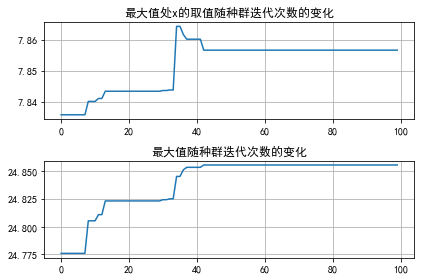

In [10]:
# iters = np.arange(0, iterations)
iters = [i for i in range(0, iterations)]
x = [i[0] for i in max_score]
y = [i[1] for i in max_score]
plt.subplot(2,1,1)
plt.title("最大值处x的取值随种群迭代次数的变化")
plt.grid(True)  #设置显示网格
plt.plot(iters, x )
plt.subplot(212)
plt.title("最大值随种群迭代次数的变化")
plt.plot(iters, y )
plt.grid(True)  #设置显示网格
#plt.savefig('data_graphs', dpi=600)
plt.tight_layout()#调整子图之间间距
plt.show()

In [11]:
x = 7.857
score = x + 10*np.sin(5*x) + 7*np.cos(4*x)
print(score)

24.8553510213
